In [1]:
# Add root directory to path
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.path.abspath('..'),
                  os.pardir)
)
sys.path.append(PROJECT_ROOT)
print(sys.path)

# Imports
from electronTransportCode.SimOptions import WaterPhantomSimulation
from electronTransportCode.SimulationDomain import SimulationDomain
from electronTransportCode.MCParticleTracer import AnalogParticleTracer, MCParticleTracer
from electronTransportCode.MCEstimator import DoseEstimator
from electronTransportCode.ProjectUtils import ERE
from electronTransportCode.ParticleModel import SimplifiedEGSnrcElectron
from electronTransportCode.ProjectUtils import E_THRESHOLD, Z_WATER_EFF
from electronTransportCode.Material import WaterMaterial, Material

['/home/klaas/Documents/KUL/thesis/electronTransportCode/numericalExperiments/waterPhantom', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/klaas/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/home/klaas/Documents/codes/yt', '/usr/lib/python3/dist-packages', '/home/klaas/Documents/KUL/thesis/electronTransportCode']


In [2]:
# Set up initial conditions
eInit: float = 5/ERE  # 5 MeV initial energy
energyCutOff: float = E_THRESHOLD
SEED: int = 4  # Random number generator seed
xVariance: float = 0.1  # Variance on initial position in x and y direction
waterPhantomInit = WaterPhantomSimulation(minEnergy=energyCutOff, Esource=eInit, xVariance=xVariance, rngSeed=SEED)

In [3]:
# Set up simulation domain
simDomain = SimulationDomain(-2.5, 7.5, -2.5, 7.5, 200, 200)

# Set up dose estimator
doseEstimator = DoseEstimator(simDomain=simDomain)

# Set up particle
particle = SimplifiedEGSnrcElectron(generator=SEED)  # rng is later overridden by simulation object 

# Set up particle tracer
particleTracer = AnalogParticleTracer(particle=particle, simOptions=waterPhantomInit, simDomain=simDomain)

### Plot Stopping power for sanity check

Note:
- Figures 1.2 in Olbrant plots the elastic scattering cross section. Could be usefull in the future, but not plotted here because it is not used.

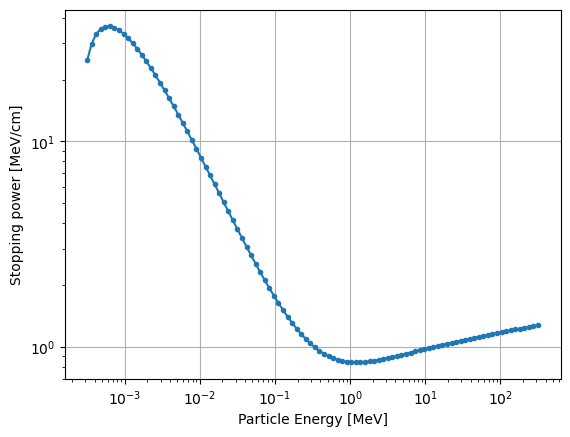

In [4]:
# Compare to figure 1.9 in Olbrant. From this, we see the figure was made was Z = 1.
M1 = Material(Z=1)
logrange = np.logspace(-3.5, 2.5, 100)  # MeV
stopping_power = np.array([particle.evalStoppingPower(E/ERE, M1)*ERE for E in logrange])  # MeV/cm

plt.figure(1)
plt.loglog(logrange, stopping_power, '.-')
plt.xlabel('Particle Energy [MeV]')
plt.ylabel('Stopping power [MeV/cm]')
plt.grid()

### Do simulation

In [5]:
# Run simulation
NB_PARTICLES = 20
particleTracer(nbParticles=NB_PARTICLES, estimator=doseEstimator)
print(f'Average amount of events: {particleTracer.averageNbCollisions}')

Average amount of events: 6394.55


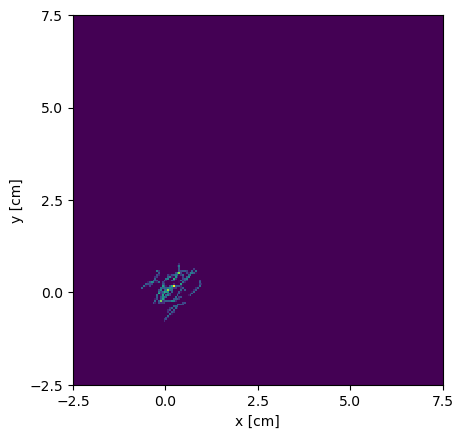

In [6]:
# Plot energy deposition
energyDeposition_ERE = np.reshape(doseEstimator.scoreMatrix, (simDomain.ybins, simDomain.xbins) )

fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.matshow(energyDeposition_ERE, extent=[-2.5, 7.5, -2.5, 7.5], origin='lower')
ax.set_xticks(np.linspace(-2.5, 7.5, 5))
ax.set_yticks(np.linspace(-2.5, 7.5, 5))
ax.xaxis.tick_bottom()
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
plt.show()
